# Clothes Classifier

In [3]:
from fastai import *
from fastai.vision import *

## Get Data

In [4]:
classes = ['jeans','trousers','jacket', 'shorts', 'tshirt', 'buttonup']
path = Path('data/clothes')

# Create folder structure
for folder in classes:
    file = "urls_" + folder + ".csv"
    
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/folder/file, dest, max_pics=500)

# Clean invalid images
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

jeans


trousers


jacket


shorts


tshirt


buttonup


## Stage 1

(['buttonup', 'jacket', 'jeans', 'shorts', 'trousers', 'tshirt'], 6, 1536, 384)

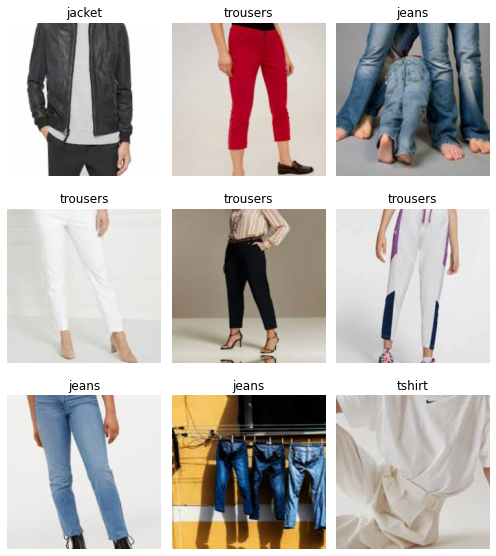

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [6]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [7]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.812937,0.639243,0.216146,0.783854,00:06
1,1.201700,0.588763,0.192708,0.807292,00:05
2,0.937148,0.636132,0.210938,0.789062,00:05
3,0.734934,0.618166,0.210938,0.789062,00:05


In [8]:
learner.save('stage-1')

In [9]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

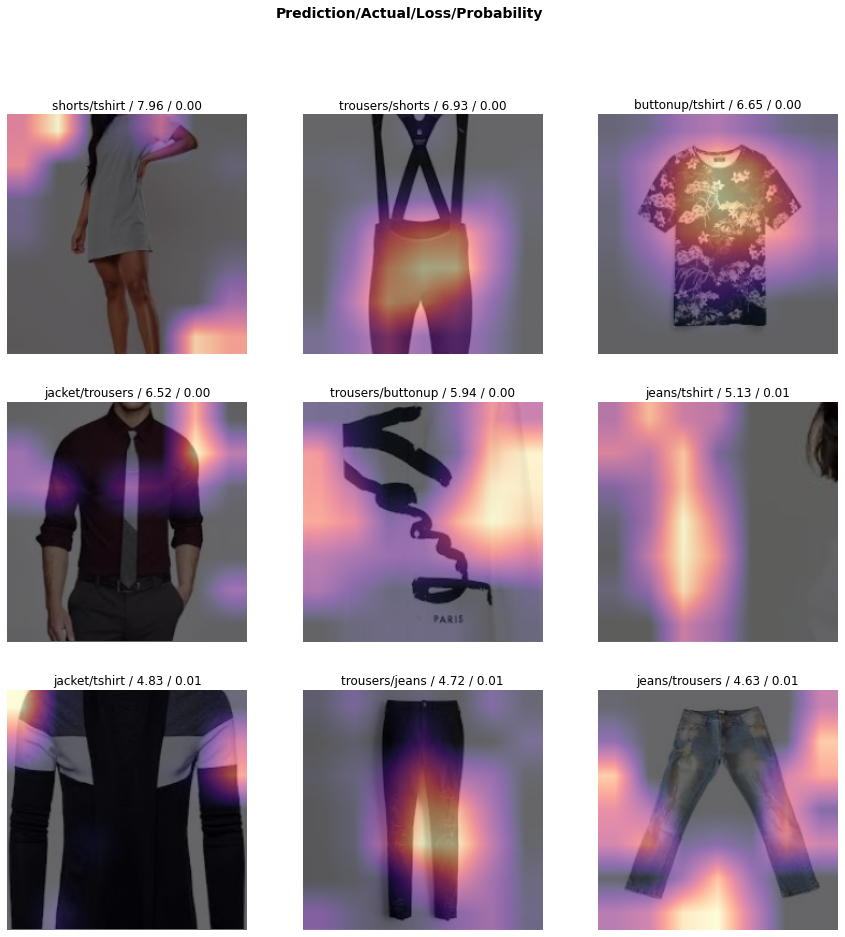

In [10]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)

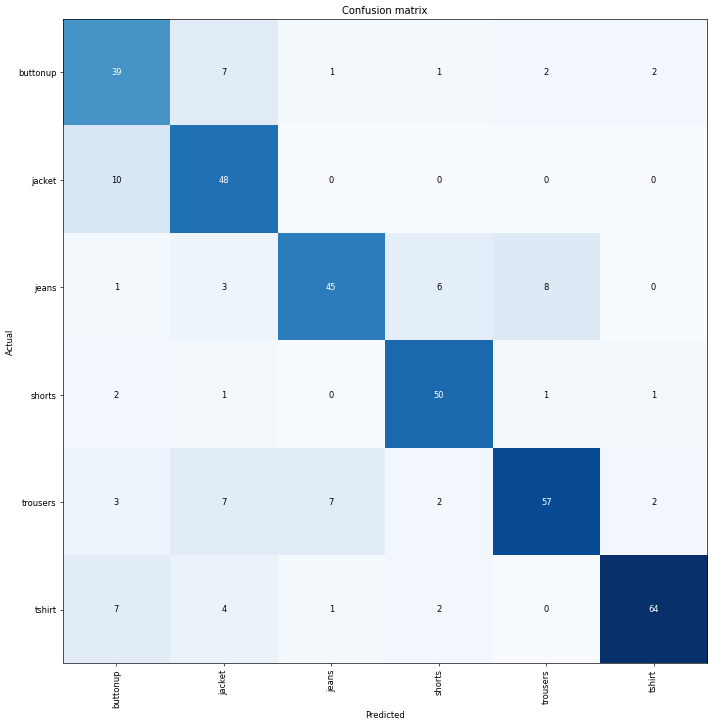

In [11]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Stage 2

In [12]:
learner.load('stage-1');

In [13]:
learner.unfreeze()

In [14]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


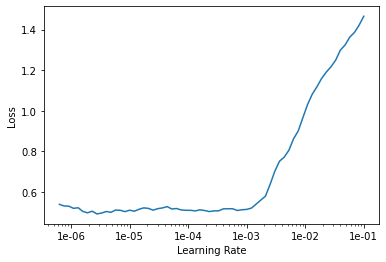

In [15]:
learner.recorder.plot()

In [16]:
learner.fit_one_cycle(8, max_lr=slice(5e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.501468,0.583670,0.197917,0.802083,00:05
1,0.424723,0.496805,0.161458,0.838542,00:05
2,0.394448,0.477151,0.151042,0.848958,00:05
3,0.322358,0.456473,0.143229,0.856771,00:05
4,0.265970,0.442738,0.143229,0.856771,00:05
5,0.231694,0.417826,0.132812,0.867188,00:05
6,0.199355,0.416612,0.119792,0.880208,00:05
7,0.172384,0.417613,0.127604,0.872396,00:05


In [17]:
learner.save('stage-2')

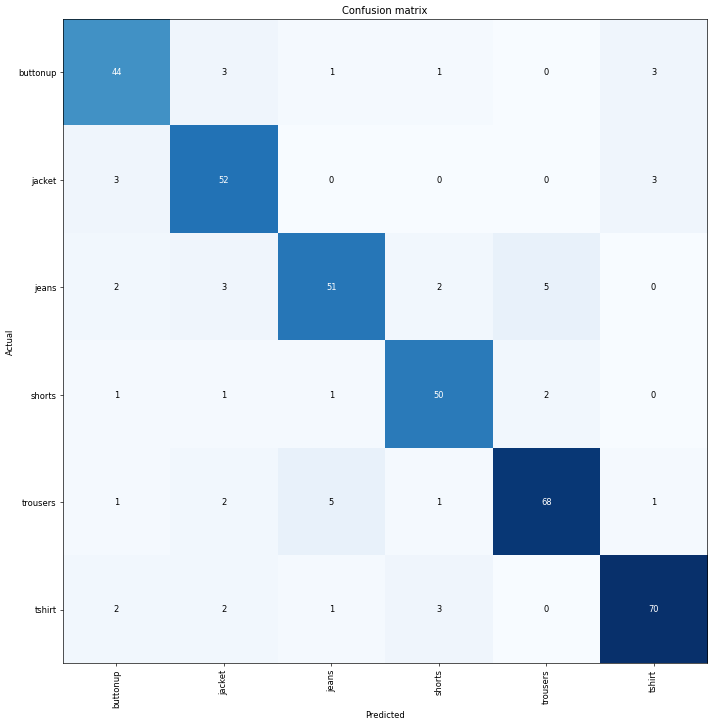

In [18]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Cleanup

In [19]:
from fastai.widgets import *

### Top Losses 

In [20]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [21]:
learn_clean = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_clean.load('stage-2');

In [23]:
ds, idxs = DatasetFormatter().from_toplosses(learn_clean)

In [24]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Duplicates

In [25]:
# Load data from the new cleaned.csv
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [26]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
     )

In [27]:
ds, idxs = DatasetFormatter().from_similars(learn_clean)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Retrain

(['buttonup', 'jacket', 'jeans', 'shorts', 'trousers', 'tshirt'], 6, 1534, 383)

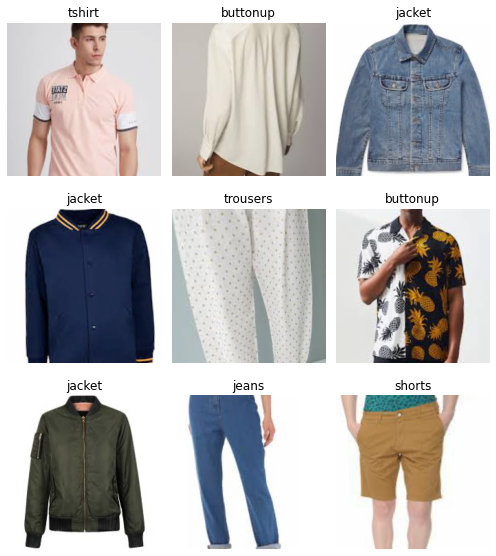

In [5]:
# Load data from the new cleaned.csv
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [6]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [7]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.852881,0.719795,0.258486,0.741514,00:06
1,1.235173,0.635095,0.201044,0.798956,00:05
2,0.944925,0.686354,0.206266,0.793734,00:05
3,0.769012,0.643263,0.203655,0.796345,00:05
4,0.641651,0.620551,0.206266,0.793734,00:05


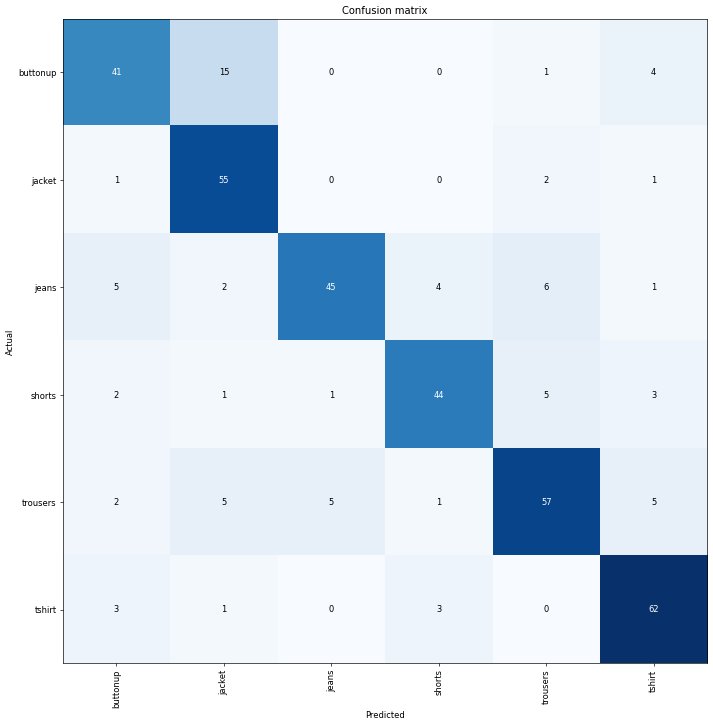

In [8]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

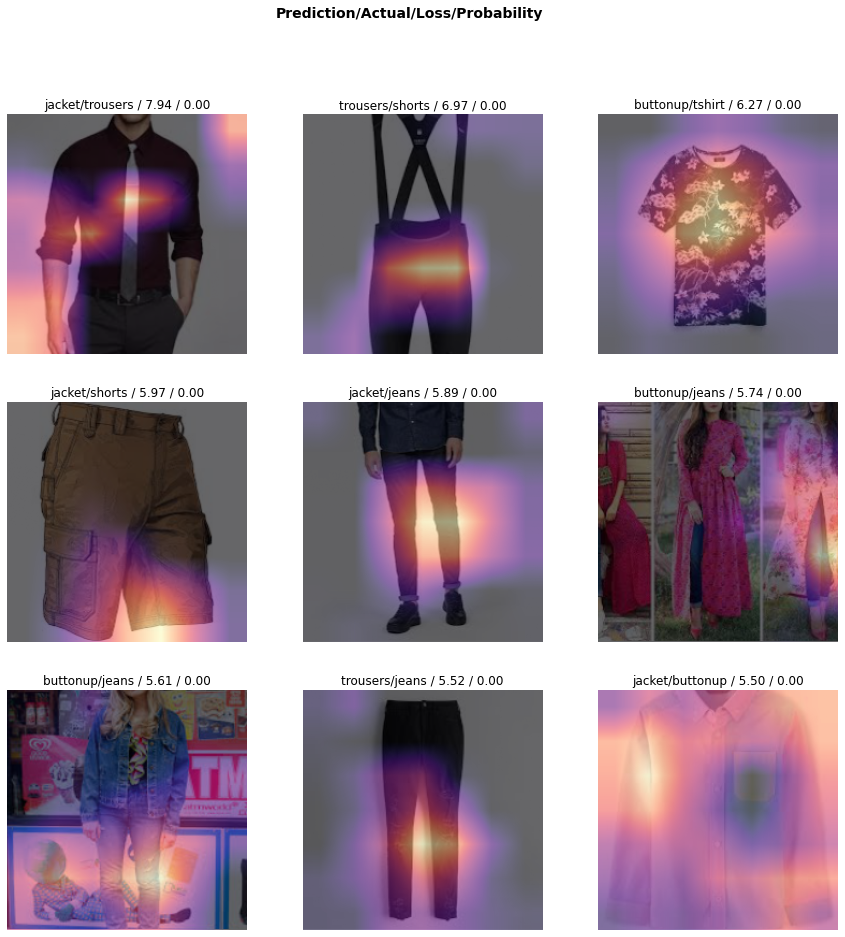

In [9]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)

In [10]:
learner.unfreeze()

In [11]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


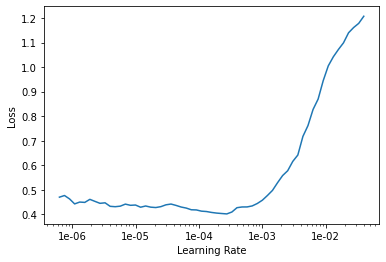

In [12]:
learner.recorder.plot()

In [13]:
learner.save('stage-3')

In [28]:
learner.load('stage-3');

In [29]:
learner.fit_one_cycle(5, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.443046,0.594327,0.185379,0.814621,00:05
1,0.406988,0.556254,0.177546,0.822454,00:05
2,0.364467,0.548273,0.177546,0.822454,00:05
3,0.335439,0.524677,0.164491,0.835509,00:05
4,0.317196,0.529047,0.167102,0.832898,00:05


In [30]:
learner.save('stage-4')